# Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import PIL
from PIL import Image
from skimage.measure import compare_psnr

import tensorflow
import keras
from keras import optimizers
from keras.backend import tf as ktf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Lambda, Concatenate

from common_utils import *
from inpainting_utils import *
from SkipNet import *

Using TensorFlow backend.


In [3]:
imsize = 512

# Read Image

In [4]:
# fig. 7 (bottom)
# f = './data/restoration/barbara.png'

# fig. 14 of supmat
f = './data/restoration/kate.png'

img_pil, img_np = get_image(f, imsize)

if 'barbara' in f:
    img_np = nn.ReflectionPad2d(1)(np_to_torch(img_np))[0].numpy()
    img_pil = np_to_pil(img_np)
    
    img_mask = get_bernoulli_mask(img_pil, 0.50)
    img_mask_np = pil_to_np(img_mask)
    
elif 'kate' in f:
    img_mask = get_bernoulli_mask(img_pil, 0.2)
    img_mask_np = pil_to_np(img_mask)
    
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
else:
    assert False
    

img_masked = img_np * img_mask_np


In [5]:
img_masked.shape

(3, 512, 512)

In [6]:
img_mask_np.shape

(3, 512, 512)

# Setup

In [7]:
INPUT = 'noise'
input_depth = 32

LR = 0.001
num_iter = 1000
reg_noise_std = 0.00

# Build

In [8]:
#get noise input
net_input = get_noise(input_depth, INPUT, img_np.shape[1:])

In [9]:
net_input.shape

(1, 512, 512, 32)

In [10]:
input_shape = net_input.shape[1:]

In [11]:
img_np = img_np.reshape((1, imsize, imsize, 3))

In [12]:
img_mask_np = img_mask_np.reshape((1, imsize, imsize, 3))

In [13]:
img_masked = img_masked.reshape((1, imsize, imsize, 3))

In [14]:
model = build_skip_net(4, 4, input_shape)

W0804 17:44:22.248175 4657878464 deprecation_wrapper.py:119] From /Users/lucasmeng/anaconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 17:44:22.282517 4657878464 deprecation_wrapper.py:119] From /Users/lucasmeng/anaconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 17:44:22.298101 4657878464 deprecation_wrapper.py:119] From /Users/lucasmeng/anaconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 17:44:22.367274 4657878464 deprecation_wrapper.py:119] From /Users/lucasmeng/anaconda3/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Pl

Shape after downsample: (?, 32, 32, 128)


W0804 17:44:28.562985 4657878464 deprecation_wrapper.py:119] From /Users/lucasmeng/DeepImagePrior/SkipNet.py:36: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.



Shape after upsample: (?, 512, 512, 32)
Output shape: (?, 512, 512, 3)


In [15]:
from keras.losses import mean_squared_error

def mse_mask(y_true, y_pred):
    return mean_squared_error(y_true * img_mask_np, y_pred * img_mask_np)

In [16]:
adam = optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

model.compile(loss=mse_mask, optimizer=adam, metrics=['mse'])

model.summary()

W0804 17:44:32.153241 4657878464 deprecation_wrapper.py:119] From /Users/lucasmeng/anaconda3/envs/py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 32) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 4624        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Train

Iter # 0 , PSRN MASKES:  28.94738837481246 ; PSRN GT:  27.688513355542817


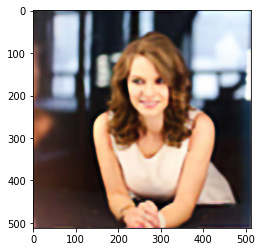

Iter # 1 , PSRN MASKES:  29.30098109934533 ; PSRN GT:  28.01108289836369


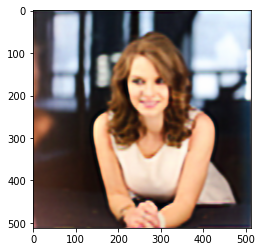

Iter # 2 , PSRN MASKES:  29.319919104406736 ; PSRN GT:  28.026926195166844


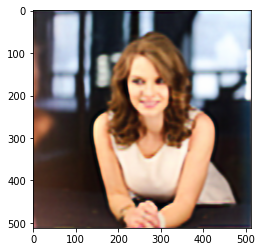

Iter # 3 , PSRN MASKES:  29.375050130133786 ; PSRN GT:  28.07167177930338


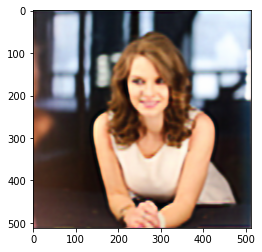

Iter # 4 , PSRN MASKES:  29.404743152982498 ; PSRN GT:  28.098769961612767


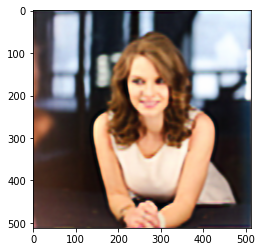

Iter # 5 , PSRN MASKES:  29.30533453162523 ; PSRN GT:  28.00588559166783


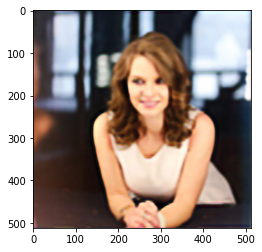

Iter # 6 , PSRN MASKES:  29.404895746064025 ; PSRN GT:  28.094847526538288


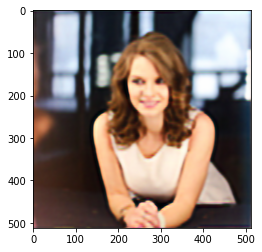

Iter # 7 , PSRN MASKES:  29.457558528078952 ; PSRN GT:  28.136271310526727


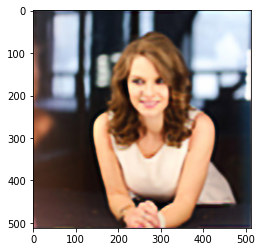

Iter # 8 , PSRN MASKES:  29.484789115542476 ; PSRN GT:  28.159698543757568


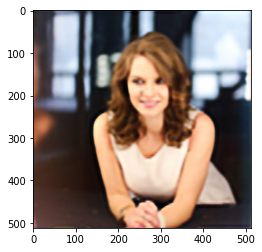

Iter # 9 , PSRN MASKES:  29.165379075831087 ; PSRN GT:  27.872927407061677


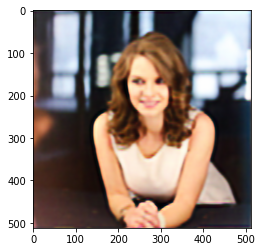

Iter # 10 , PSRN MASKES:  29.41986328471286 ; PSRN GT:  28.09946312937302


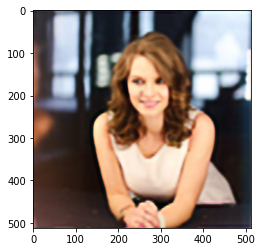

Iter # 11 , PSRN MASKES:  29.42437473981758 ; PSRN GT:  28.106237504472155


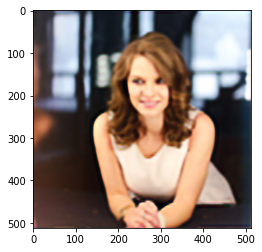

Iter # 12 , PSRN MASKES:  28.895741558969704 ; PSRN GT:  27.62380061667361


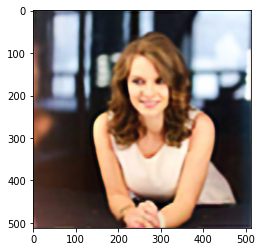

Iter # 13 , PSRN MASKES:  29.294815017454717 ; PSRN GT:  27.981053856669714


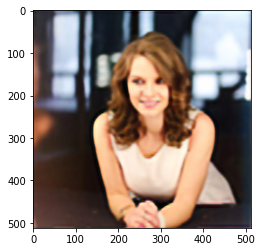

Iter # 14 , PSRN MASKES:  29.495057066393485 ; PSRN GT:  28.16202330574548


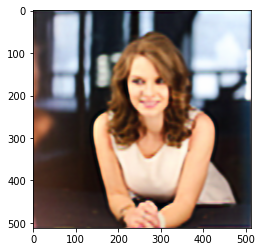

Iter # 15 , PSRN MASKES:  29.479254738463958 ; PSRN GT:  28.142629085800557


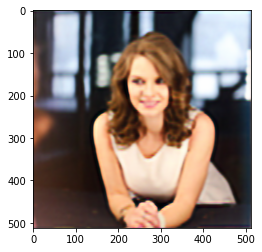

Iter # 16 , PSRN MASKES:  29.50942565245594 ; PSRN GT:  28.165313398688898


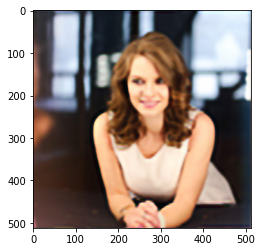

Iter # 17 , PSRN MASKES:  29.512679291461787 ; PSRN GT:  28.16822801119709


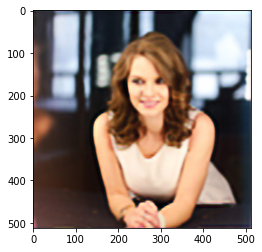

Iter # 18 , PSRN MASKES:  26.692552300635963 ; PSRN GT:  25.54767839197249


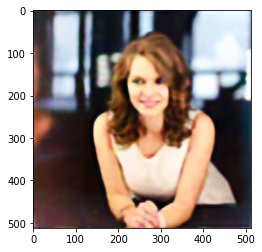

Iter # 19 , PSRN MASKES:  28.330970031805506 ; PSRN GT:  27.091803410670355


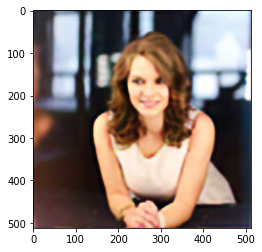

Iter # 20 , PSRN MASKES:  29.24131690742238 ; PSRN GT:  27.931140425787106


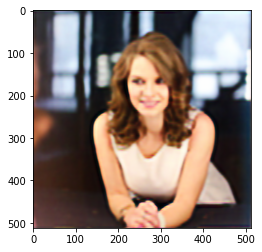

Iter # 21 , PSRN MASKES:  29.454922287542754 ; PSRN GT:  28.12001515076939


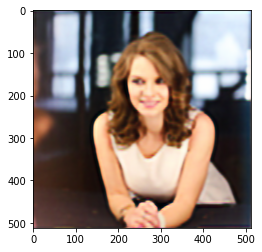

Iter # 22 , PSRN MASKES:  29.454723366222886 ; PSRN GT:  28.117468316693582


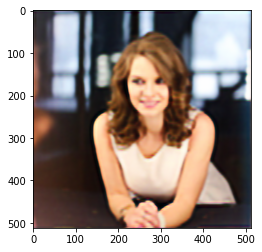

Iter # 23 , PSRN MASKES:  29.401197491748295 ; PSRN GT:  28.068729310120595


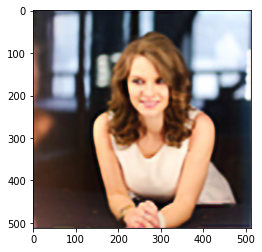

Iter # 24 , PSRN MASKES:  29.320822830274082 ; PSRN GT:  27.989674194918596


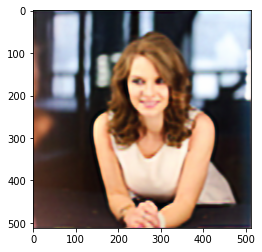

Iter # 25 , PSRN MASKES:  29.439901177726703 ; PSRN GT:  28.09259404379646


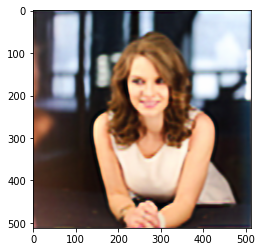

Iter # 26 , PSRN MASKES:  29.41215836440829 ; PSRN GT:  28.064778720818524


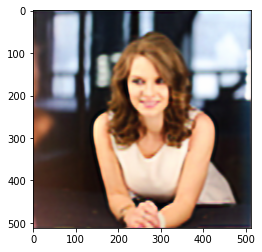

Iter # 27 , PSRN MASKES:  29.449818276363313 ; PSRN GT:  28.095260268766694


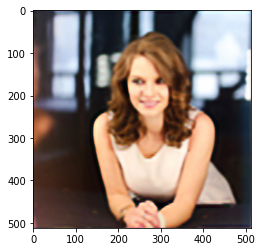

Iter # 28 , PSRN MASKES:  28.97289079004837 ; PSRN GT:  27.65215445274488


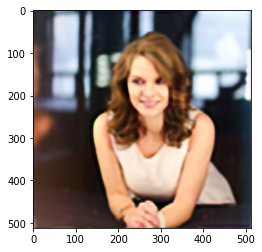

Iter # 29 , PSRN MASKES:  29.605761323324735 ; PSRN GT:  28.226657248512023


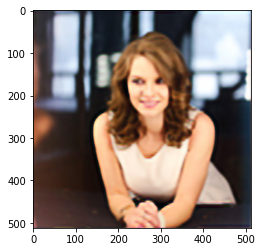

Iter # 30 , PSRN MASKES:  29.637434888783392 ; PSRN GT:  28.251189709782338


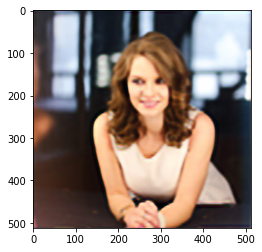

Iter # 31 , PSRN MASKES:  29.648619687405308 ; PSRN GT:  28.26005645486582


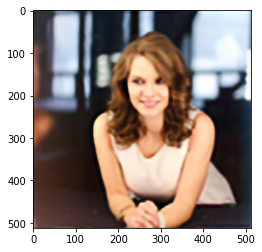

Iter # 32 , PSRN MASKES:  29.543519189489427 ; PSRN GT:  28.16595202912836


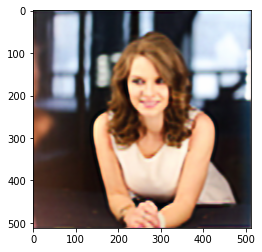

Iter # 33 , PSRN MASKES:  29.625080959050877 ; PSRN GT:  28.23333584473022


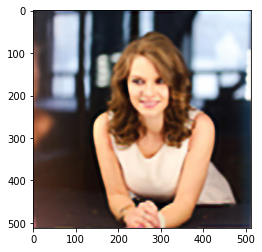

Iter # 34 , PSRN MASKES:  29.57946082477319 ; PSRN GT:  28.18949186962613


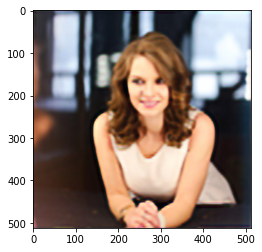

Iter # 35 , PSRN MASKES:  29.605454029963546 ; PSRN GT:  28.212969176648592


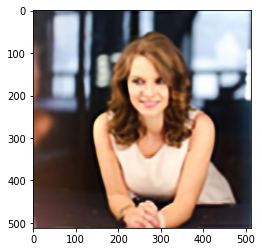

Iter # 36 , PSRN MASKES:  29.63235790365642 ; PSRN GT:  28.22919937157025


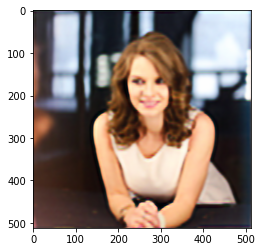

Iter # 37 , PSRN MASKES:  29.337971102553414 ; PSRN GT:  27.97149678515177


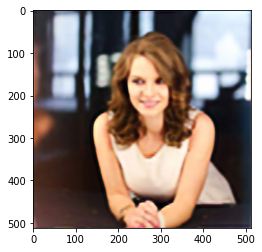

Iter # 38 , PSRN MASKES:  29.648312262164357 ; PSRN GT:  28.243920886204293


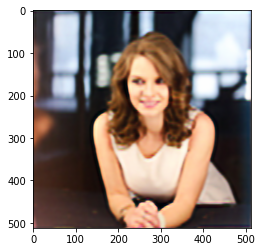

Iter # 39 , PSRN MASKES:  29.608828849368358 ; PSRN GT:  28.21310011613148


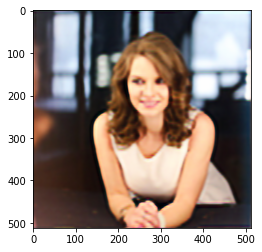

Iter # 40 , PSRN MASKES:  29.407724175323324 ; PSRN GT:  28.031166776208533


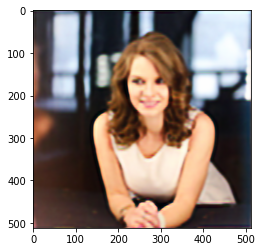

Iter # 41 , PSRN MASKES:  28.253491059354374 ; PSRN GT:  26.98450777571262


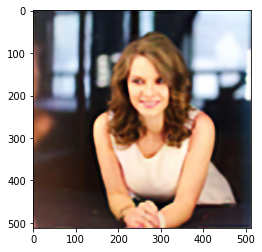

Iter # 42 , PSRN MASKES:  29.508599561141352 ; PSRN GT:  28.117439860870732


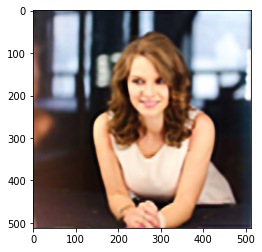

Iter # 43 , PSRN MASKES:  29.671221398313648 ; PSRN GT:  28.254963829145442


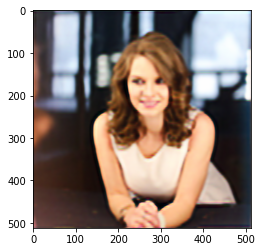

Iter # 44 , PSRN MASKES:  29.611335000360036 ; PSRN GT:  28.20326053694295


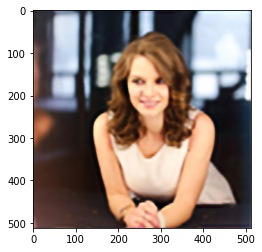

Iter # 45 , PSRN MASKES:  29.634855903443725 ; PSRN GT:  28.21994437362877


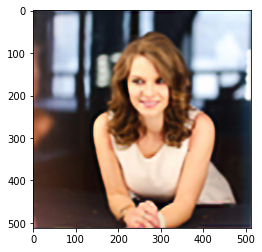

Iter # 46 , PSRN MASKES:  29.64743668491815 ; PSRN GT:  28.22691228743793


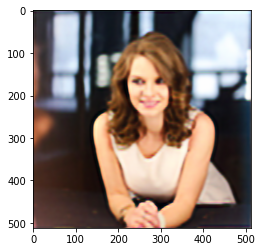

Iter # 47 , PSRN MASKES:  29.456637400233888 ; PSRN GT:  28.06094145149519


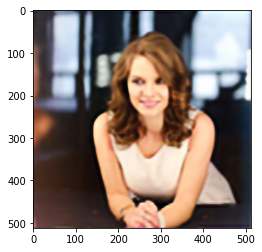

Iter # 48 , PSRN MASKES:  29.691454672551302 ; PSRN GT:  28.261970130736778


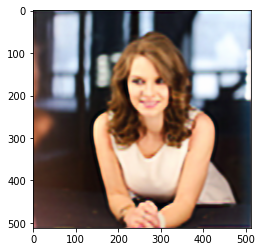

Iter # 49 , PSRN MASKES:  29.115789647850892 ; PSRN GT:  27.744156788002186


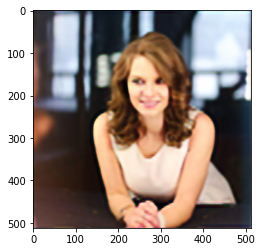

In [20]:
for i in range(50):
    model.fit(net_input, img_np, verbose=0, epochs=50)
    out = model.predict(net_input)
    psrn_masked = compare_psnr(img_masked[0], out[0] * img_mask_np[0]) 
    psrn_gt = compare_psnr(img_np[0], out[0])
    print("Iter #", i, ", PSRN MASKES: ", psrn_masked, "; PSRN GT: ", psrn_gt)
    
    out = out.reshape((3, imsize, imsize))
    plt.imshow(out.transpose(1, 2, 0), interpolation='lanczos')
    plt.show()
    
#     net_input += np.random.standard_normal(net_input.shape) * reg_noise_std
#     get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0]))

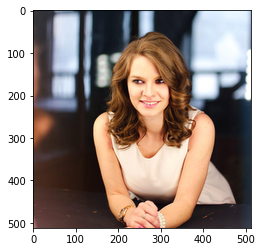

In [17]:
img = img_np.reshape((3, imsize, imsize))
plt.imshow(img.transpose(1, 2, 0), interpolation='lanczos')
plt.show()

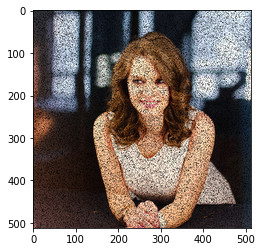

In [18]:
img = img_masked.reshape((3, imsize, imsize))
plt.imshow(img.transpose(1, 2, 0), interpolation='lanczos')
plt.show()